## Install depedncies

In [12]:
!pip install -U langchain langchain-community langchain-experimental replicate pandas matplotlib

## Import Library

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata
from langchain_community.llms import Replicate
from tqdm import tqdm

## Set API Token for Replicate

In [5]:
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

## Load IBM granite

In [6]:
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct"
)

## Load Dataset

In [9]:
def load_fasttext_file(filepath):
    data = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                label, review = parts
                data.append((label, review))
    return pd.DataFrame(data, columns=["label", "review"])

df = load_fasttext_file("test.ft.txt")

label_map = {"__label__1": "negative", "__label__2": "positive"}
df["sentiment_label"] = df["label"].map(label_map)

print("✅ Dataset Loaded Successfully")
print(df.head(10))

✅ Dataset Loaded Successfully
        label                                             review  \
0  __label__2  Great CD: My lovely Pat has one of the GREAT v...   
1  __label__2  One of the best game music soundtracks - for a...   
2  __label__1  Batteries died within a year ...: I bought thi...   
3  __label__2  works fine, but Maha Energy is better: Check o...   
4  __label__2  Great for the non-audiophile: Reviewed quite a...   
5  __label__1  DVD Player crapped out after one year: I also ...   
6  __label__1  Incorrect Disc: I love the style of this, but ...   
7  __label__1  DVD menu select problems: I cannot scroll thro...   
8  __label__2  Unique Weird Orientalia from the 1930's: Exoti...   
9  __label__1  Not an "ultimate guide": Firstly,I enjoyed the...   

  sentiment_label  
0        positive  
1        positive  
2        negative  
3        positive  
4        positive  
5        negative  
6        negative  
7        negative  
8        positive  
9        negative  


## Promt for sentiment classification

## Sentiment Classification (row-by-row)

In [10]:
def classify_review(text):
    prompt = f"""
    Classify the following product review into one of these categories:
    - positive
    - negative
    - neutral

    Review: {text}
    Answer with only one word: positive, negative, or neutral.
    """
    try:
        result = llm.invoke(prompt)
        return result.strip().lower()
    except Exception:
        return "error"

sample_df = df.head(50).copy()
preds = []
for r in tqdm(sample_df["review"]):
    preds.append(classify_review(r))
sample_df["predicted_sentiment"] = preds

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


## Analytical Result

In [14]:
print("\n=== Analytical Result ===")
print(sample_df[["review", "sentiment_label", "predicted_sentiment"]].head(10))

distribution = sample_df["predicted_sentiment"].value_counts()
print("\nDistribution:")
print(distribution)

accuracy = (sample_df["predicted_sentiment"] == sample_df["sentiment_label"]).mean()
print(f"\nAccuracy: {accuracy:.2%}")


=== Analytical Result ===
                                              review sentiment_label  \
0  Great CD: My lovely Pat has one of the GREAT v...        positive   
1  One of the best game music soundtracks - for a...        positive   
2  Batteries died within a year ...: I bought thi...        negative   
3  works fine, but Maha Energy is better: Check o...        positive   
4  Great for the non-audiophile: Reviewed quite a...        positive   
5  DVD Player crapped out after one year: I also ...        negative   
6  Incorrect Disc: I love the style of this, but ...        negative   
7  DVD menu select problems: I cannot scroll thro...        negative   
8  Unique Weird Orientalia from the 1930's: Exoti...        positive   
9  Not an "ultimate guide": Firstly,I enjoyed the...        negative   

  predicted_sentiment  
0            positive  
1            positive  
2            negative  
3            negative  
4            positive  
5            negative  
6           

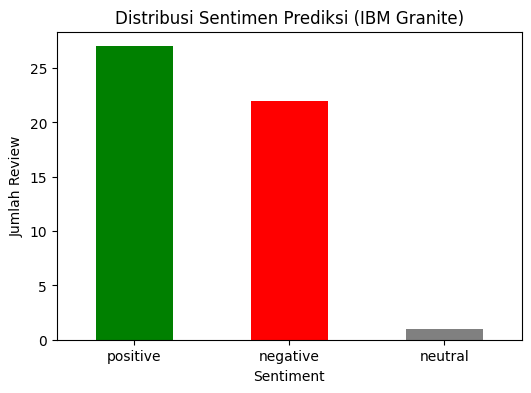

In [17]:
plt.figure(figsize=(6, 4))
distribution.plot(kind="bar", color=["green", "red", "gray"])
plt.title("Distribusi Sentimen Prediksi (IBM Granite)")
plt.xlabel("Sentiment")
plt.ylabel("Jumlah Review")
plt.xticks(rotation=0)
plt.show()

## Insight & Findings

In [15]:
insight_prompt = f"""
You are a data analyst. Based on the following sentiment analysis results,
summarize the insights in clear and logical points.
Focus on what the distribution and accuracy imply about customer sentiment.

Distribution:
{distribution.to_dict()}
Accuracy: {accuracy:.2%}
"""
insights = llm.invoke(insight_prompt)
print("\n=== Insight & Findings ===")
print(insights)


=== Insight & Findings ===
1. The sentiment analysis results indicate a slightly positive overall sentiment, as the 'positive' category (27 instances) outnumbers the 'negative' category (22 instances). The 'neutral' category is minimal (1 instance), suggesting that customers are predominantly positive but with a noticeable negative sentiment as well.

2. The accuracy of 96.00% suggests that the sentiment analysis model is highly reliable and precise in classifying customer sentiments. This high accuracy implies that the model's interpretation of customer feedback is consistent and trustworthy.

3. The distribution shows that a significant portion of customer feedback is positive (approximately 55%), indicating a generally favorable view of the product, service, or topic under consideration. However, the substantial negative sentiment (approximately 45%) signifies areas for improvement and potential issues that need attention.

4. The relatively low number of neutral sentiments (1 inst

## Recommendations

In [16]:
recommendation_prompt = f"""
Based on the insights below, provide 3-5 clear, concrete, and actionable
recommendations for an e-commerce company to improve their business.

Insights:
{insights}
"""
recommendations = llm.invoke(recommendation_prompt)
print("\n=== Recommendations ===")
print(recommendations)


=== Recommendations ===
1. **Prioritize Negative Feedback**: Given that 45% of the sentiments are negative, the e-commerce company should prioritize addressing these concerns. This can be achieved by categorizing the common issues raised in negative feedback and allocating resources to resolve them systematically. For instance, if a significant number of negative sentiments relate to shipping delays, invest in improving logistics or setting clearer customer expectations.

2. **Leverage Positive Feedback for Marketing**: With 55% of sentiments being positive, the company should utilize this feedback for marketing purposes. Sharing testimonials, reviews, and success stories on their website, social media, and email campaigns can enhance credibility and attract new customers. This approach not only capitalizes on existing positive sentiment but also encourages potential customers to share similar positive experiences.

3. **Implement a Customer Feedback Loop**: Given the clear-cut opinio